<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи-и-данных" data-toc-modified-id="Описание-задачи-и-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи и данных</a></span></li><li><span><a href="#Импорт-модулей" data-toc-modified-id="Импорт-модулей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт модулей</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Работа-со-временем" data-toc-modified-id="Работа-со-временем-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Работа со временем</a></span></li><li><span><a href="#Работа-с-количеством-позиций-в-заказах" data-toc-modified-id="Работа-с-количеством-позиций-в-заказах-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Работа с количеством позиций в заказах</a></span></li></ul></li><li><span><a href="#Предсказание" data-toc-modified-id="Предсказание-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Предсказание</a></span></li></ul></div>

**Наши контакты:**

* Григорян Лаврентий, tg: **@lawrence_grig**

* Илюхин Андрей, tg: **@Andrey_xiaoan**

# Описание задачи и данных

**Ключевая метрика**

доля мультизаказов = кол-во заказов, которые доставлялись вместе с другими / общее количество заказов

**Задача:**

По данным выборки  оцените, какая доля заказов выборки  могла бы доставляться с помощью мультизаказов во всех городах, где представлены рестораны выборки?

Имеется неизвестный нам алгоритм по объединению заказов и результат его работы на выборке ресторанов А. В задаче нужно предсказать поведение алгоритма на выборке ресторанов B. Скачать данные можно на странице с описанием задачи, в формате .xlsx. Это не привычный нам по курсу формат .csv, и смена расширения на .csv здесь не сработает. Поэтому первым делом вам нужно найти способ загрузить эти данные в Python.

Рассмотрим по очереди, что означает каждый столбец:

* brand_name. Это и есть выборка ресторанов (А или В). Все строки с brand_name == А - это реальные обезличенные данные о заказах в Яндекс Еде, при этом работал алгоритм, объединяющий некоторые заказы (не более двух!). Все строки с brand_name == В - это тоже реальные данные о заказах, но в других ресторанах, для которых алгоритм объдинения заказов не работал. Ваша задача - предсказать, какой процент заказов был бы объединен, если бы работал алгоритм объединения. Например, если у нас всего 3 заказа, и первый объединен со вторым, то объединено 66.7% заказов.


* rest_id. Идентификатор конкретного ресторана (то есть конкретного адреса, откуда курьер забирает заказ). Заказы могут объединяться только если у них один и тот же rest_id.


* order_id. Уникальный идентификатор заказа.


* batched_with_order_id. Идентификатор заказа, объединенного с текущим (при наличии). Очевидно, что в выборке В это поле всегда пусто.


* first_in_multiorder_flg. Является ли заказ первым в мультизаказе (при объединении двух заказов).


* courier_id. Уникальный идентификатор курьера.


* order_items_cnt. Количество позиций в заказе.


* city. Уникальный идентификатор города. Все заказы выборки А принадлежат одному и тому же городу, а вот в выборке В есть разные города.


* order_created_datetime. Время создания заказа. Обратите внимание, указан 2015 год, но это не значит, что задача старая. Дело в том, что данные обезличены, и все даты тоже изменены.

# Импорт модулей


In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import seaborn as sns
import catboost

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

np.set_printoptions(suppress=True)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = 8, 4
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Анализ данных

Прочитаем данные и посмотрим на базовую информацию по ним:

In [2]:
data = pd.read_excel('yandex_hack.xlsx', sheet_name='result 1')
data.head()

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
0,2015-09-15 21:08:43.000000,B,7cc98331ddb8ccffe464455f3df763d9,NaN,0b6f25c79b35fd1e6d28d845b7ee511d,NaN,3f1b96f620988a92d3409ea05e87bd36,3,c6fbacc5cab7e134c9db2a4bbfcc5b64
1,2015-09-13 18:40:12.000000,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,793f2fa9aa3d52d2da05caa3c30cb77e,NaN,8ed37467dc9b257b3b3bdc1bfebd9b28,8,e6705560085199e9674cd721ee844d0d
2,2015-09-14 01:52:40.000000,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,b6c5ec927a3e314b0900c103a0cd68fa,NaN,5b17547f825d9cf35c7853621dd842f8,1,e6705560085199e9674cd721ee844d0d
3,2015-09-13 17:23:52.000000,B,7cc98331ddb8ccffe464455f3df763d9,NaN,5dc658f0928569dbefac74c9f311031c,NaN,81647a72700bd46635d9606082360cc8,6,c6fbacc5cab7e134c9db2a4bbfcc5b64
4,2015-09-13 11:15:05.000000,B,7cc98331ddb8ccffe464455f3df763d9,NaN,3da09410aeab781baf4b7039fc9b125c,NaN,065c18216b6d3369d4cc36418c6e80f2,7,c6fbacc5cab7e134c9db2a4bbfcc5b64


In [3]:
# Для удобства скопируем исходный датасет
df = data.copy(deep=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66464 entries, 0 to 66463
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_created_datetime   66464 non-null  object 
 1   brand_name               66464 non-null  object 
 2   rest_id                  66464 non-null  object 
 3   batched_with_order_id    442 non-null    object 
 4   order_id                 66464 non-null  object 
 5   first_in_multiorder_flg  442 non-null    float64
 6   courier_id               66202 non-null  object 
 7   order_items_cnt          66464 non-null  int64  
 8   city                     66464 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.6+ MB


In [5]:
print(f'Количество дублирующихся строк: {df.duplicated().sum()}')

Количество дублирующихся строк: 0


Извлечем из имеющихся данных признаки, которые могут быть полезны в анализе работы алгоритма:

In [6]:
# Приведем даты в нужный тип данных
df['order_created_datetime'] = pd.to_datetime(df['order_created_datetime'])

# Извлечем час заказа
df['hour'] = df['order_created_datetime'].dt.hour

In [7]:
# Пометим мультизаказы лэйблом (1 - мульти, 0 - не мульти)
df['multi'] = 0
multi_indices = df[~df['batched_with_order_id'].isna()].index
df.iloc[multi_indices, -1] = 1

Разделим данные на два датасета:

1. На датасете с выборкой **А** будем проводить анализ и проверять определенные гипотезы;

2. На датасете с выборкой **В** будем непосредственно моделировать работу алгоритма.

In [8]:
df_a = df[df['brand_name'] == 'A']
df_b = df[df['brand_name'] == 'B']

In [9]:
# Размеры выборок
df_a.shape, df_b.shape

((9629, 11), (56835, 11))

In [10]:
# Взглянем на информацию по датасету А
df_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9629 entries, 1 to 66463
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_created_datetime   9629 non-null   datetime64[ns]
 1   brand_name               9629 non-null   object        
 2   rest_id                  9629 non-null   object        
 3   batched_with_order_id    442 non-null    object        
 4   order_id                 9629 non-null   object        
 5   first_in_multiorder_flg  442 non-null    float64       
 6   courier_id               9437 non-null   object        
 7   order_items_cnt          9629 non-null   int64         
 8   city                     9629 non-null   object        
 9   hour                     9629 non-null   int64         
 10  multi                    9629 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 902.7+ KB


In [11]:
# Взглянем на информацию по датасету B
df_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56835 entries, 0 to 66461
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_created_datetime   56835 non-null  datetime64[ns]
 1   brand_name               56835 non-null  object        
 2   rest_id                  56835 non-null  object        
 3   batched_with_order_id    0 non-null      object        
 4   order_id                 56835 non-null  object        
 5   first_in_multiorder_flg  0 non-null      float64       
 6   courier_id               56765 non-null  object        
 7   order_items_cnt          56835 non-null  int64         
 8   city                     56835 non-null  object        
 9   hour                     56835 non-null  int64         
 10  multi                    56835 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 5.2+ MB


Заметим, что по какой-то причине в обоих датасетах имеются пропущенные значения с идентификатором курьера:

In [12]:
# Определим датасет без курьеров
no_courier = df_a[df_a['courier_id'].isna()]
no_courier.head()

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,hour,multi
1122,2015-09-13 15:17:06,A,901649e552e8020ce880edf983436254,NaN,96fa94b322f1181b86cfb1a74e5dfdf6,NaN,NaN,4,8ef4fd9e60ef979b27a7ce3487dce62d,15,0
1694,2015-09-13 19:46:18,A,4d106a11291f2e158459d5a4323f3785,NaN,e899d05f13a52aeda27e9a85a6c81384,NaN,NaN,5,946eb5ac8ebfbecac00621b1a5b37cae,19,0
1716,2015-09-13 20:48:42,A,4d106a11291f2e158459d5a4323f3785,NaN,afd9ea04ceae0e04652c10fa9b1ee076,NaN,NaN,2,946eb5ac8ebfbecac00621b1a5b37cae,20,0
1731,2015-09-15 10:06:26,A,4d106a11291f2e158459d5a4323f3785,NaN,c338524c86aaea1b55eca0e981f31634,NaN,NaN,7,946eb5ac8ebfbecac00621b1a5b37cae,10,0
1967,2015-09-14 23:41:23,A,29d14913bb48d6f9e245eb1d6727ad59,NaN,978e4369060a5c7bf0f958d525f0b96f,NaN,NaN,4,9a8fe36e44485af8b9e4b6352043555d,23,0


In [13]:
# Есть ли мультизаказы в таких данных
no_courier_multi = no_courier[no_courier['multi'] == 1].shape[0]
print(f'Количество мультизаказов с отсутствующими данными по курьеру: {no_courier_multi}')

Количество мультизаказов с отсутствующими данными по курьеру: 0


* Видим, что в данных с пропущенным id курьера не имеется мультизаказов


* Теоретически, это могут быть отмененные заказы (например, через приложение не был найден курьер)


* Возможно, в дальнейшем можно будет опустить эти данные, пока этого делать не будем - **ментор подтвердил догадку о том, что отсутствие курьера означает отмену заказа** - удаляем эти данные

In [14]:
# Удаляем отмененные заказы
df_a = df_a[~df_a['courier_id'].isna()]
df_b = df_b[~df_b['courier_id'].isna()]

Посмотрим на сами мультизаказы:

In [15]:
multis = df[df['multi'] == 1].sort_values(['rest_id',
                                           'order_created_datetime'])
multis

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,hour,multi
25294,2015-09-13 11:54:31,A,03e61cfb9d3325c7c88accd2b3cfa2be,e0c4053a9330db0c071077c417a186fc,87b092f55dca7eafdcfff64c80b22c89,1.0,4e3243405d91b074e142849272d56ea8,6,e6705560085199e9674cd721ee844d0d,11,1
25007,2015-09-13 11:58:16,A,03e61cfb9d3325c7c88accd2b3cfa2be,87b092f55dca7eafdcfff64c80b22c89,e0c4053a9330db0c071077c417a186fc,0.0,4e3243405d91b074e142849272d56ea8,4,e6705560085199e9674cd721ee844d0d,11,1
25113,2015-09-14 13:03:42,A,03e61cfb9d3325c7c88accd2b3cfa2be,22042ce802550d0ecfbd4538999b934a,d056858f86f04033f6452a4b2298b53b,0.0,c3d886736250b57f14dbe80289b32333,4,e6705560085199e9674cd721ee844d0d,13,1
24937,2015-09-14 13:05:35,A,03e61cfb9d3325c7c88accd2b3cfa2be,d056858f86f04033f6452a4b2298b53b,22042ce802550d0ecfbd4538999b934a,1.0,c3d886736250b57f14dbe80289b32333,2,e6705560085199e9674cd721ee844d0d,13,1
25696,2015-09-15 12:44:52,A,03e61cfb9d3325c7c88accd2b3cfa2be,516facafc232ed15fae79fb44e8eefc0,da6b8ee82b7e184594d83a4b3f5c4196,0.0,7fcca23af76a79d23625e2c7de118dff,5,e6705560085199e9674cd721ee844d0d,12,1
...,...,...,...,...,...,...,...,...,...,...,...
10581,2015-09-13 10:37:06,A,fd4886dc87654f153f5640c90c6766cc,cd51180695ac23bead7ff649d9cba8ab,360a08f1ce9e78499f156d84afb39d44,0.0,eb1f606aff7e990f68396cd19ba1427d,8,e6705560085199e9674cd721ee844d0d,10,1
10909,2015-09-13 13:10:38,A,fd4886dc87654f153f5640c90c6766cc,248f41938d395a519c8a23037c6c5bff,40e2f8a7a779249f7e91a4c3e742742c,1.0,4a6b01a85a58429768651bc1a9bb35fb,6,e6705560085199e9674cd721ee844d0d,13,1
10513,2015-09-13 13:15:25,A,fd4886dc87654f153f5640c90c6766cc,40e2f8a7a779249f7e91a4c3e742742c,248f41938d395a519c8a23037c6c5bff,0.0,4a6b01a85a58429768651bc1a9bb35fb,5,e6705560085199e9674cd721ee844d0d,13,1
10413,2015-09-13 18:22:36,A,fd4886dc87654f153f5640c90c6766cc,a7e19f5d66ed4495bb7d372252b6e16d,2600a26313e169fd097eea322808b8d0,1.0,4a6b01a85a58429768651bc1a9bb35fb,2,e6705560085199e9674cd721ee844d0d,18,1


> * На данном этапе можно заметить, что разница во времени между двумя заказами, взятыми курьером в одном ресторане, минимальная (на первый взгляд 2-10 мин.)


> * В дальнейшем статистически проверим, в действительности ли всё так

> * При этом всего уникальных мульти заказов 221, поскольку мультизаказы, условно говоря, дублируют друг друга в разном порядке

## Работа со временем

**Гипотеза 1:** время между заказами из одного ресторана значительно определяет то, возьмет ли курьер 2 заказа сразу

*H0 (нулевая гипотеза):* среднее время, прошедшее между заказами, скомпонованными в мультизаказ, не отличается от среднего времени между остальными заказами

*Ha (альтернативная гипотеза):* разница в среднем времени между данными группами заказов есть 

Сгруппируем датасет по ресторанам и отсортируем по дате, поскольку, не имея данных о геолокации ресторана, логично предположить, что мультизаказ возможно взять исключительно из одного ресторана:

**Рассмотрим датасет с группой ресторанов А:**

In [16]:
df_a = df_a.sort_values(by=['rest_id',
                            'order_created_datetime'])
df_a.head()

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,hour,multi
38339,2015-09-13 08:17:37,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,7908bfeca488df5e4a85346125a674f6,NaN,773835e5b274dc34215f703b347116c4,5,b6a1beaea9592d98e402ec9af5c4f507,8,0
38038,2015-09-13 08:54:49,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,b03469ecd4dc89f82231afa94f237799,NaN,773835e5b274dc34215f703b347116c4,4,b6a1beaea9592d98e402ec9af5c4f507,8,0
38020,2015-09-13 09:18:56,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,43cc485f0196b07b8769317f634e0190,NaN,44f35e01f8798209b68f92e6f3932a26,6,b6a1beaea9592d98e402ec9af5c4f507,9,0
38185,2015-09-13 13:27:27,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,6a50ccc686b066f346c63b9e55265fd9,NaN,ff2053790febc58b41784ac5d64cc5ba,6,b6a1beaea9592d98e402ec9af5c4f507,13,0
37779,2015-09-13 15:18:46,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,257b521bc3b8f734987757552ee06af0,NaN,6e85cd77ce1462d1150f5123bd0a4789,4,b6a1beaea9592d98e402ec9af5c4f507,15,0


In [17]:
# Отберем мультизаказы в отдельный датасет
multi = df_a[df_a['multi'] == 1]
multi.head(20)

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,hour,multi
25294,2015-09-13 11:54:31,A,03e61cfb9d3325c7c88accd2b3cfa2be,e0c4053a9330db0c071077c417a186fc,87b092f55dca7eafdcfff64c80b22c89,1.0,4e3243405d91b074e142849272d56ea8,6,e6705560085199e9674cd721ee844d0d,11,1
25007,2015-09-13 11:58:16,A,03e61cfb9d3325c7c88accd2b3cfa2be,87b092f55dca7eafdcfff64c80b22c89,e0c4053a9330db0c071077c417a186fc,0.0,4e3243405d91b074e142849272d56ea8,4,e6705560085199e9674cd721ee844d0d,11,1
25113,2015-09-14 13:03:42,A,03e61cfb9d3325c7c88accd2b3cfa2be,22042ce802550d0ecfbd4538999b934a,d056858f86f04033f6452a4b2298b53b,0.0,c3d886736250b57f14dbe80289b32333,4,e6705560085199e9674cd721ee844d0d,13,1
24937,2015-09-14 13:05:35,A,03e61cfb9d3325c7c88accd2b3cfa2be,d056858f86f04033f6452a4b2298b53b,22042ce802550d0ecfbd4538999b934a,1.0,c3d886736250b57f14dbe80289b32333,2,e6705560085199e9674cd721ee844d0d,13,1
25696,2015-09-15 12:44:52,A,03e61cfb9d3325c7c88accd2b3cfa2be,516facafc232ed15fae79fb44e8eefc0,da6b8ee82b7e184594d83a4b3f5c4196,0.0,7fcca23af76a79d23625e2c7de118dff,5,e6705560085199e9674cd721ee844d0d,12,1
25595,2015-09-15 12:50:25,A,03e61cfb9d3325c7c88accd2b3cfa2be,da6b8ee82b7e184594d83a4b3f5c4196,516facafc232ed15fae79fb44e8eefc0,1.0,7fcca23af76a79d23625e2c7de118dff,6,e6705560085199e9674cd721ee844d0d,12,1
24908,2015-09-15 15:39:21,A,03e61cfb9d3325c7c88accd2b3cfa2be,f7504cca61bfd9b9352b5b8691ef2b0b,c051e3cae6a5939a4301842cb5e2c8fc,1.0,7fcca23af76a79d23625e2c7de118dff,3,e6705560085199e9674cd721ee844d0d,15,1
25456,2015-09-15 15:41:56,A,03e61cfb9d3325c7c88accd2b3cfa2be,c051e3cae6a5939a4301842cb5e2c8fc,f7504cca61bfd9b9352b5b8691ef2b0b,0.0,7fcca23af76a79d23625e2c7de118dff,10,e6705560085199e9674cd721ee844d0d,15,1
27165,2015-09-14 20:45:01,A,05759cc0a86c0976b8e1dbe593bd22a0,4acea49a192d223a223244e55c40dfd3,0b91bc85666b8a6e6b0c8a86dde6a081,0.0,177c4b90affe688bb5e78ae17473f1e6,4,e6705560085199e9674cd721ee844d0d,20,1
26956,2015-09-14 20:46:45,A,05759cc0a86c0976b8e1dbe593bd22a0,0b91bc85666b8a6e6b0c8a86dde6a081,4acea49a192d223a223244e55c40dfd3,1.0,177c4b90affe688bb5e78ae17473f1e6,5,e6705560085199e9674cd721ee844d0d,20,1


Создадим признак, показывающий, сколько всего прошло времени в минутах между двумя заказами, переданными одному курьеру:

In [18]:
multi['timedelta'] = multi['order_created_datetime'].diff().dt.total_seconds() / 60

Поскольку нам нужны только разницы во времени между двумя заказами, то оставшиеся разницы необходимо удалить:

In [19]:
# Заменяем лишние разницы во времени nan-значениями
multi.iloc[np.arange(0, len(multi), 2), -1] = np.nan

In [20]:
multi[:50]

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,hour,multi,timedelta
25294,2015-09-13 11:54:31,A,03e61cfb9d3325c7c88accd2b3cfa2be,e0c4053a9330db0c071077c417a186fc,87b092f55dca7eafdcfff64c80b22c89,1.0,4e3243405d91b074e142849272d56ea8,6,e6705560085199e9674cd721ee844d0d,11,1,NaN
25007,2015-09-13 11:58:16,A,03e61cfb9d3325c7c88accd2b3cfa2be,87b092f55dca7eafdcfff64c80b22c89,e0c4053a9330db0c071077c417a186fc,0.0,4e3243405d91b074e142849272d56ea8,4,e6705560085199e9674cd721ee844d0d,11,1,3.750000
25113,2015-09-14 13:03:42,A,03e61cfb9d3325c7c88accd2b3cfa2be,22042ce802550d0ecfbd4538999b934a,d056858f86f04033f6452a4b2298b53b,0.0,c3d886736250b57f14dbe80289b32333,4,e6705560085199e9674cd721ee844d0d,13,1,NaN
24937,2015-09-14 13:05:35,A,03e61cfb9d3325c7c88accd2b3cfa2be,d056858f86f04033f6452a4b2298b53b,22042ce802550d0ecfbd4538999b934a,1.0,c3d886736250b57f14dbe80289b32333,2,e6705560085199e9674cd721ee844d0d,13,1,1.883333
25696,2015-09-15 12:44:52,A,03e61cfb9d3325c7c88accd2b3cfa2be,516facafc232ed15fae79fb44e8eefc0,da6b8ee82b7e184594d83a4b3f5c4196,0.0,7fcca23af76a79d23625e2c7de118dff,5,e6705560085199e9674cd721ee844d0d,12,1,NaN
25595,2015-09-15 12:50:25,A,03e61cfb9d3325c7c88accd2b3cfa2be,da6b8ee82b7e184594d83a4b3f5c4196,516facafc232ed15fae79fb44e8eefc0,1.0,7fcca23af76a79d23625e2c7de118dff,6,e6705560085199e9674cd721ee844d0d,12,1,5.550000
24908,2015-09-15 15:39:21,A,03e61cfb9d3325c7c88accd2b3cfa2be,f7504cca61bfd9b9352b5b8691ef2b0b,c051e3cae6a5939a4301842cb5e2c8fc,1.0,7fcca23af76a79d23625e2c7de118dff,3,e6705560085199e9674cd721ee844d0d,15,1,NaN
25456,2015-09-15 15:41:56,A,03e61cfb9d3325c7c88accd2b3cfa2be,c051e3cae6a5939a4301842cb5e2c8fc,f7504cca61bfd9b9352b5b8691ef2b0b,0.0,7fcca23af76a79d23625e2c7de118dff,10,e6705560085199e9674cd721ee844d0d,15,1,2.583333
27165,2015-09-14 20:45:01,A,05759cc0a86c0976b8e1dbe593bd22a0,4acea49a192d223a223244e55c40dfd3,0b91bc85666b8a6e6b0c8a86dde6a081,0.0,177c4b90affe688bb5e78ae17473f1e6,4,e6705560085199e9674cd721ee844d0d,20,1,NaN
26956,2015-09-14 20:46:45,A,05759cc0a86c0976b8e1dbe593bd22a0,0b91bc85666b8a6e6b0c8a86dde6a081,4acea49a192d223a223244e55c40dfd3,1.0,177c4b90affe688bb5e78ae17473f1e6,5,e6705560085199e9674cd721ee844d0d,20,1,1.733333


In [21]:
# Посчитаем среднее время между заказами
mean_time = multi['timedelta'].mean()
print(f'В среднем между заказами, входящими в мультизаказ, проходит {np.round(mean_time, 3)} мин.')

В среднем между заказами, входящими в мультизаказ, проходит 9.262 мин.


Посмотрим на распределение разницы во времени. Для этого напишем функцию, строющую необходимые графики с минимальным количеством кода:

In [22]:
def dist_box(data, column: str):
    """
    Строит распределение и ящик с усами
    для заданного датасета и его столбца
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    sns.distplot(data[column], ax=axes[0], color='m')
    axes[0].set_title(f'Распределение для {column}')
    axes[0].set_xlabel(f'{column}')

    sns.boxplot(data[column], ax=axes[1])
    axes[1].set_title(f'Боксплот для {column}')
    axes[1].set_xlabel(f'{column}')

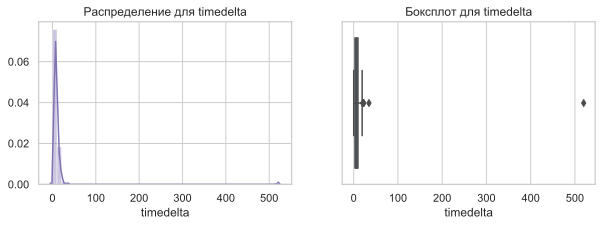

In [23]:
# Распределение разницы во времени для мультизаказов
dist_box(multi, 'timedelta')

* Из графика видно, что основная часть наблюдений распределена достаточно близко к нулю

* Однако есть одно экстремальное значение больше 500 мин. и еще пара наблюдений со значениями больше 30 мин., которые стоит удалить как выбросы

In [24]:
# Удаляем выбросы
multi = multi[multi['timedelta'] < 18]

In [25]:
# Посмотрим на среднее теперь
mean_time = multi['timedelta'].mean()
print(f'В среднем между заказами, входящими в мультизаказ, проходит {np.round(mean_time, 3)} мин.')

В среднем между заказами, входящими в мультизаказ, проходит 6.355 мин.


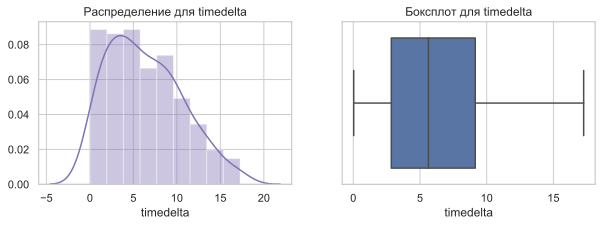

In [26]:
# Еще раз посмотрим на распределение после удаления выбросов
dist_box(multi, 'timedelta')

* После удаления выбросов, составляющих малую часть всей выборки, распределение данной переменной стало гораздо ближе к нормальному


* Видим, что подавляющая часть мультизаказов формируется из тех заказов, между которыми прошло примерно 3-8 минут


**Теперь необходимо посмотреть, сколько в среднем проходит времени между заказами одного ресторана, не скомпонованными в мультизаказ:**

In [27]:
not_multi = df_a[df_a['multi'] == 0]
not_multi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8995 entries, 38339 to 31548
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_created_datetime   8995 non-null   datetime64[ns]
 1   brand_name               8995 non-null   object        
 2   rest_id                  8995 non-null   object        
 3   batched_with_order_id    0 non-null      object        
 4   order_id                 8995 non-null   object        
 5   first_in_multiorder_flg  0 non-null      float64       
 6   courier_id               8995 non-null   object        
 7   order_items_cnt          8995 non-null   int64         
 8   city                     8995 non-null   object        
 9   hour                     8995 non-null   int64         
 10  multi                    8995 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 843.3+ KB


In [28]:
# Выведем данные по стандартным заказам
not_multi

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,hour,multi
38339,2015-09-13 08:17:37,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,7908bfeca488df5e4a85346125a674f6,NaN,773835e5b274dc34215f703b347116c4,5,b6a1beaea9592d98e402ec9af5c4f507,8,0
38038,2015-09-13 08:54:49,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,b03469ecd4dc89f82231afa94f237799,NaN,773835e5b274dc34215f703b347116c4,4,b6a1beaea9592d98e402ec9af5c4f507,8,0
38020,2015-09-13 09:18:56,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,43cc485f0196b07b8769317f634e0190,NaN,44f35e01f8798209b68f92e6f3932a26,6,b6a1beaea9592d98e402ec9af5c4f507,9,0
38185,2015-09-13 13:27:27,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,6a50ccc686b066f346c63b9e55265fd9,NaN,ff2053790febc58b41784ac5d64cc5ba,6,b6a1beaea9592d98e402ec9af5c4f507,13,0
37779,2015-09-13 15:18:46,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,257b521bc3b8f734987757552ee06af0,NaN,6e85cd77ce1462d1150f5123bd0a4789,4,b6a1beaea9592d98e402ec9af5c4f507,15,0
...,...,...,...,...,...,...,...,...,...,...,...
30943,2015-09-14 17:45:38,A,ff3b46f6abdf1fa1b262783ab3d96b55,NaN,cb93db4787c827b5c1a6285d683c42be,NaN,a0e2d3e2bf5d0af07d8beef2c959846a,4,e6705560085199e9674cd721ee844d0d,17,0
30878,2015-09-14 19:03:48,A,ff3b46f6abdf1fa1b262783ab3d96b55,NaN,b212f6242f41e77239f105cfb86a9a31,NaN,293cc5c6c0e2af7e3e4f03c18ab1ef78,2,e6705560085199e9674cd721ee844d0d,19,0
30957,2015-09-15 15:19:19,A,ff3b46f6abdf1fa1b262783ab3d96b55,NaN,e57d1becd75c6bfd95fe5f996a9c7fa2,NaN,93906090df9a3279dadd258f82f051ae,3,e6705560085199e9674cd721ee844d0d,15,0
31766,2015-09-15 19:41:30,A,ff3b46f6abdf1fa1b262783ab3d96b55,NaN,91bc4405842c2657f1aed3a9e31cc37e,NaN,1cebb1d1da285d7191e4e6a72ccaf32a,5,e6705560085199e9674cd721ee844d0d,19,0


Теперь найдем разницу во времени между одиночными заказами среди заказов каждого ресторана, для чего вновь создадим признак **timedelta**:

In [29]:
not_multi['timedelta'] = not_multi.groupby(['rest_id'])['order_created_datetime'].apply(lambda group: group.diff().dt.total_seconds() / 60)[:50]
not_multi.head(40)

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,hour,multi,timedelta
38339,2015-09-13 08:17:37,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,7908bfeca488df5e4a85346125a674f6,NaN,773835e5b274dc34215f703b347116c4,5,b6a1beaea9592d98e402ec9af5c4f507,8,0,NaN
38038,2015-09-13 08:54:49,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,b03469ecd4dc89f82231afa94f237799,NaN,773835e5b274dc34215f703b347116c4,4,b6a1beaea9592d98e402ec9af5c4f507,8,0,37.200000
38020,2015-09-13 09:18:56,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,43cc485f0196b07b8769317f634e0190,NaN,44f35e01f8798209b68f92e6f3932a26,6,b6a1beaea9592d98e402ec9af5c4f507,9,0,24.116667
38185,2015-09-13 13:27:27,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,6a50ccc686b066f346c63b9e55265fd9,NaN,ff2053790febc58b41784ac5d64cc5ba,6,b6a1beaea9592d98e402ec9af5c4f507,13,0,248.516667
37779,2015-09-13 15:18:46,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,257b521bc3b8f734987757552ee06af0,NaN,6e85cd77ce1462d1150f5123bd0a4789,4,b6a1beaea9592d98e402ec9af5c4f507,15,0,111.316667
38405,2015-09-13 16:31:07,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,b1a18998c697c1153c456fa7141e6b2a,NaN,12254294b607a8c0e8762a9a9b021121,3,b6a1beaea9592d98e402ec9af5c4f507,16,0,72.350000
37876,2015-09-13 16:49:23,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,64b9b3ff4fcc682b1802ea84368d0f29,NaN,12254294b607a8c0e8762a9a9b021121,4,b6a1beaea9592d98e402ec9af5c4f507,16,0,18.266667
38140,2015-09-13 17:51:30,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,88bbe131493a320ef49c11b6e0847012,NaN,44f35e01f8798209b68f92e6f3932a26,5,b6a1beaea9592d98e402ec9af5c4f507,17,0,62.116667
38024,2015-09-13 17:51:37,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,d59ed0081c7c0bf52b1c6f60c04fb535,NaN,6e85cd77ce1462d1150f5123bd0a4789,4,b6a1beaea9592d98e402ec9af5c4f507,17,0,0.116667
38280,2015-09-13 17:52:56,A,0045f2feaafc5218f9d1ce2b2554557b,NaN,284740f21a2086a35a034050817845d8,NaN,f7e1ab6657feaa715ea5ad5694313dbb,6,b6a1beaea9592d98e402ec9af5c4f507,17,0,1.316667


Найдем среднюю разницу между одиночными заказами в минутах:

In [30]:
mean_time = not_multi['timedelta'].mean()
print(f'В среднем между одиночными заказами, не вошедшими в мультизаказ, проходит {np.round(mean_time, 3)} мин.')

В среднем между одиночными заказами, не вошедшими в мультизаказ, проходит 231.085 мин.


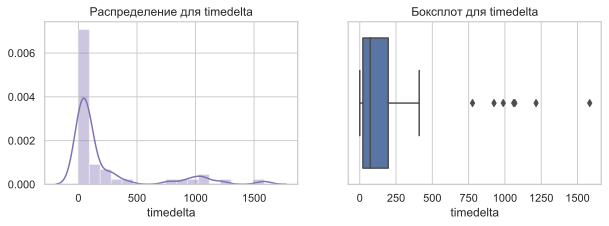

In [31]:
# Распределение разницы между одиночными заказами
dist_box(not_multi, 'timedelta')

Удалим выбросы и посмотрим на среднее и распределение еще раз:

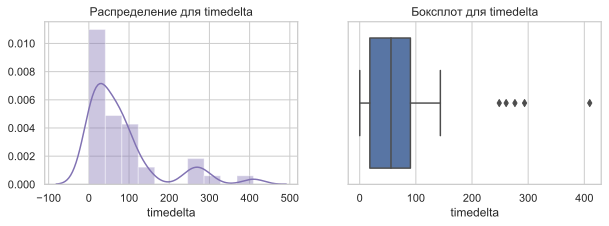

In [32]:
not_multi = not_multi[not_multi['timedelta'] <= 500]
dist_box(not_multi, 'timedelta')

In [33]:
mean_time = not_multi['timedelta'].mean()
print(f'В среднем между заказами, входящими в мультизаказ, проходит {np.round(mean_time, 3)} мин.')

В среднем между заказами, входящими в мультизаказ, проходит 81.092 мин.


> После удаления выбросов показатель среднего количества времени, прошедшего между одиночными заказами все еще в разы больше, чем аналогичный показатель для заказов, вошедших в мультизаказ

Проверим имеющуюся статистическую гипотезу с помощью непараметрического **критерия Манна-Уитни** (ввиду отсутствия нормального распределения в данных):

In [34]:
sample_1 = multi['timedelta']
sample_2 = not_multi['timedelta']
mwu = sp.stats.mannwhitneyu(sample_1, sample_2)

if mwu.pvalue < 0.01:
    print(f'p-value{np.round(mwu.pvalue, 2)} < 0.01 => отвергаем нулевую гипотезу')
else:
    print(f'p-value{np.round(mwu.pvalue, 2)} > 0.01 => не отвергаем нулевую гипотезу')

p-value0.0 < 0.01 => отвергаем нулевую гипотезу


Таким образом, с 99% уверенностью можно утверждать о наличии статистически значимых различий в среднем значении прошедшего между двумя заказами времени для мультизаказов и обычных заказов.

## Работа с количеством позиций в заказах

**Гипотеза 2**: количество позиций в заказе определяет возможность курьера взять мультизаказ

*H0:* нет различий в среднем количестве позиций в заказе среди мультизаказов и обычных заказов

*Ha:* различия имеются

In [35]:
# Определим мультизаказы
multi = df_a[df_a['multi'] == 1]
multi.head()

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,hour,multi
25294,2015-09-13 11:54:31,A,03e61cfb9d3325c7c88accd2b3cfa2be,e0c4053a9330db0c071077c417a186fc,87b092f55dca7eafdcfff64c80b22c89,1.0,4e3243405d91b074e142849272d56ea8,6,e6705560085199e9674cd721ee844d0d,11,1
25007,2015-09-13 11:58:16,A,03e61cfb9d3325c7c88accd2b3cfa2be,87b092f55dca7eafdcfff64c80b22c89,e0c4053a9330db0c071077c417a186fc,0.0,4e3243405d91b074e142849272d56ea8,4,e6705560085199e9674cd721ee844d0d,11,1
25113,2015-09-14 13:03:42,A,03e61cfb9d3325c7c88accd2b3cfa2be,22042ce802550d0ecfbd4538999b934a,d056858f86f04033f6452a4b2298b53b,0.0,c3d886736250b57f14dbe80289b32333,4,e6705560085199e9674cd721ee844d0d,13,1
24937,2015-09-14 13:05:35,A,03e61cfb9d3325c7c88accd2b3cfa2be,d056858f86f04033f6452a4b2298b53b,22042ce802550d0ecfbd4538999b934a,1.0,c3d886736250b57f14dbe80289b32333,2,e6705560085199e9674cd721ee844d0d,13,1
25696,2015-09-15 12:44:52,A,03e61cfb9d3325c7c88accd2b3cfa2be,516facafc232ed15fae79fb44e8eefc0,da6b8ee82b7e184594d83a4b3f5c4196,0.0,7fcca23af76a79d23625e2c7de118dff,5,e6705560085199e9674cd721ee844d0d,12,1


In [36]:
mean_ord = multi['order_items_cnt'].mean()
print(f'Среднее количество позиций в мультизаказах: {np.round(mean_ord, 2)}')

Среднее количество позиций в мультизаказах: 4.8


In [37]:
# Среднее кол-во позиций
not_multi = df_a[df_a['multi'] == 0]
mean_ord = not_multi['order_items_cnt'].mean()
print(f'Среднее количество позиций в стандартных заказах: {np.round(mean_ord, 2)}')

Среднее количество позиций в стандартных заказах: 4.85


Посмотрим на распределения выборок:

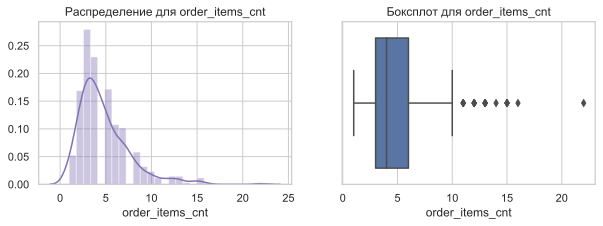

In [38]:
# Распределение позиций мультиклассов
dist_box(multi, 'order_items_cnt')

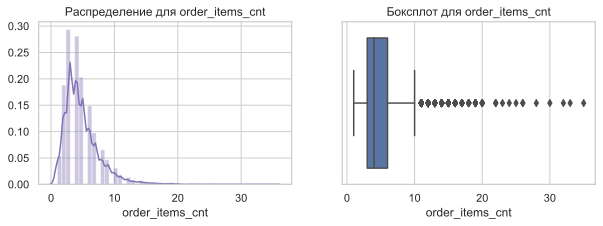

In [39]:
# Распределение позиций одиночных заказов
dist_box(not_multi, 'order_items_cnt')

Нормальное распределение вновь отсутствует. 

Воспользуемся непараметрическим критерием Манна-Уитни:

In [40]:
mwu = sp.stats.mannwhitneyu(multi['order_items_cnt'],
                            not_multi['order_items_cnt'])
pvalue = mwu.pvalue

if mwu.pvalue < 0.01:
    print(f'p-value={np.round(mwu.pvalue, 2)} < 0.01 => отвергаем нулевую гипотезу')
else:
    print(f'p-value{np.round(mwu.pvalue, 2)} > 0.01 => не отвергаем нулевую гипотезу')

p-value0.25 > 0.01 => не отвергаем нулевую гипотезу


C 99% уверенностью не отвергаем нулевую гипотезу и делаем вывод о том, что недостаточно статистических оснований, чтобы утверждать о наличии существенных различий в среднем количестве позиций в заказе по мультизаказам и одиночным заказам.

# Предсказание

Первое предсказание основываем на разнице во времени между заказами, сортируя данные по ресторанам и по дате заказа:

In [41]:
df_b = df_b.sort_values(by=['rest_id', 'order_created_datetime'])
df_b.head()

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,hour,multi
24685,2015-09-13 08:38:38,B,005dab15a06781cf716d477dfbb6a08f,NaN,3267852ec0189a55587e8417954a6eea,NaN,b5d4b8292b83f38fd7ea22a7c666ab8d,2,e6705560085199e9674cd721ee844d0d,8,0
24198,2015-09-13 09:23:22,B,005dab15a06781cf716d477dfbb6a08f,NaN,85f8d3171bc795e2ac699dbc4ab13aa7,NaN,db283da01a0bf08541afe689d5528b6a,3,e6705560085199e9674cd721ee844d0d,9,0
24248,2015-09-13 09:50:44,B,005dab15a06781cf716d477dfbb6a08f,NaN,db482fdb78173ddd5ecf13f4b3acce3b,NaN,13b5e6b7cf3bc36ecff9c7192b674379,4,e6705560085199e9674cd721ee844d0d,9,0
24776,2015-09-13 09:53:46,B,005dab15a06781cf716d477dfbb6a08f,NaN,50ee0573db2bc2270247e7d21a744d7e,NaN,db283da01a0bf08541afe689d5528b6a,4,e6705560085199e9674cd721ee844d0d,9,0
24645,2015-09-13 10:12:44,B,005dab15a06781cf716d477dfbb6a08f,NaN,adba2ee94cd859e4b65ba16657282669,NaN,db283da01a0bf08541afe689d5528b6a,2,e6705560085199e9674cd721ee844d0d,10,0


Создадим признак, показывающий прошедшее между двумя соседними заказами время (в разрезе каждого ресторана по отдельности):

In [42]:
df_b['timedelta'] = df_b.groupby(['rest_id'])['order_created_datetime']\
                        .apply(lambda group: group.diff().dt.total_seconds() / 60)

In [43]:
df_b.head()

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,hour,multi,timedelta
24685,2015-09-13 08:38:38,B,005dab15a06781cf716d477dfbb6a08f,NaN,3267852ec0189a55587e8417954a6eea,NaN,b5d4b8292b83f38fd7ea22a7c666ab8d,2,e6705560085199e9674cd721ee844d0d,8,0,NaN
24198,2015-09-13 09:23:22,B,005dab15a06781cf716d477dfbb6a08f,NaN,85f8d3171bc795e2ac699dbc4ab13aa7,NaN,db283da01a0bf08541afe689d5528b6a,3,e6705560085199e9674cd721ee844d0d,9,0,44.733333
24248,2015-09-13 09:50:44,B,005dab15a06781cf716d477dfbb6a08f,NaN,db482fdb78173ddd5ecf13f4b3acce3b,NaN,13b5e6b7cf3bc36ecff9c7192b674379,4,e6705560085199e9674cd721ee844d0d,9,0,27.366667
24776,2015-09-13 09:53:46,B,005dab15a06781cf716d477dfbb6a08f,NaN,50ee0573db2bc2270247e7d21a744d7e,NaN,db283da01a0bf08541afe689d5528b6a,4,e6705560085199e9674cd721ee844d0d,9,0,3.033333
24645,2015-09-13 10:12:44,B,005dab15a06781cf716d477dfbb6a08f,NaN,adba2ee94cd859e4b65ba16657282669,NaN,db283da01a0bf08541afe689d5528b6a,2,e6705560085199e9674cd721ee844d0d,10,0,18.966667


Данный параметр был выбран исходя из предыдущего анализа на выборке **А**, показывающего, что между подавляющим большинством заказов из мультизаказов прошло примерно не более 8 минут.

При этом важно, чтобы заказ, который был определен по временному промежутку как заказ, который может быть сформирован в мульти, не может быть скомпонован с предыдущим, если предыдущий уже отнесен к мультизаказу.

Кроме того, для подстраховки, убедимся в том, что оба заказа, являющиеся кандидатами на включение в мультизаказ, были из одного города.

**Реализуем работу алгоритма:**

In [44]:
for i in range(1, df_b.shape[0]):
    if (df_b.iloc[i]['timedelta'] < 8) and\
       (df_b.iloc[i - 1]['multi'] != 1) and\
       (df_b.iloc[i]['city'] == df_b.iloc[i - 1]['city']):
        df_b.iloc[i, -2] = 1

> Алгоритм проверяет, чтобы между двумя заказами прошло меньше 8 минут и оба заказа были из одного города, при условии, что предыдущий заказ еще не был включен в мультизаказ.

**Считаем метрику:**

In [45]:
metric = (2 * df_b['multi'].sum()) / df_b.shape[0]
print(f'Доля мультизаказов: {100 * np.round(metric, 4)}%')

Доля мультизаказов: 53.65%


Рассмотрим так же и доверительный интервал для данной доли, поскольку интервал лучше характеризует определенный показатель, чем просто число:

In [47]:
# Количество пар, входящих в мультизаказ
n = df_b['multi'].sum()

# Количество наблюдений
nobs = df_b.shape[0]

# Доверительный интервал
cf = np.array(proportion_confint(count=n*2, nobs=nobs, alpha=0.01))
print(f'99%-ый доверительный интервал для доли мультизаказов: [{cf[0]}, {cf[1]}]')

99%-ый доверительный интервал для доли мультизаказов: [0.5310660773007214, 0.5418485708099101]


Следовательно, 99% рассчитанных в ходе множества экспериментов долей мультизаказов будут входить в рассчитанный интервал.

**Согласно нашему анализу алгоритм работает следующим образом:**

1) Алгоритм сортирует все заказы по времени (дате) и группирует по ресторанам, поскольку мультизаказ может быть сформирован из одного и того же ресторана


2) Затем рассчитывается время, прошедшее между двумя последними заказами и полученное значение сравнивается с определенным порогом (например, в нашем случае - 8 мин., что было выявлено статистически)


3) Для того, чтобы в мультизаказ был сформирован исключительно из двух заказов, алгоритму необходимо убедиться, что один из заказов еще не входит в другой мультизаказ, иначе мультизаказ будет сформирован из более чем 2-х заказов, что некорректно

**Заключение:**

* Таким образом, используя алгоритм, основанный на времени, показывает, что ~53.65% всех заказов могли бы доставляться совместно с другими, что позволило бы значительно понизить затраты на оплату труда курьеров;


* При этом заказчик может корректировать работу алгоритма в зависимости от целей бизнеса. При желании оптимизировать затраты на доставку, данный способ определения мультизаказа по времени достаточно оптимален, однако в том случае, если бизнесу нужно сохранить или повысить retention клиентов, имеет смысл разработать политику о формировании мультизаказа посредством надстройки времени, прошедшего между заказами, в зависимости от времени дня и его нагруженности;


* Например, клиенты, заказывающие еду в обеденное время, скорее всего ожидают оперативности доставки, тогда как мультизаказ может понизить лояльность клиента к сервису из-за относительно долгого ожидания. Таким образом, будет повышен retention и будет сохраняться баланс между экономией на затратах на доставку и лояльностью клиентов к нашему сервису.